# Goodreads Fantasy & Paranormal Dataset - Advanced EDA

This notebook implements advanced exploratory data analysis on the Goodreads Fantasy dataset using SQLite database.

In [2]:
# Import necessary libraries
import logging
import os
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings("ignore")

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

%matplotlib inline
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",
        "axes.labelsize": 12,
        "font.size": 11,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

## 1. Database Connection

Functions to connect to the SQLite database.

In [3]:
def connect_to_db(db_path="goodreads.db"):
    """Connect to SQLite database."""
    if not os.path.exists(db_path):
        #get root directory
        project_root = os.getcwd()
        # go up twice 
        project_root = os.path.dirname(os.path.dirname(project_root))
        alternative_path = os.path.join(project_root, "data", "goodreads.db")

        if os.path.exists(alternative_path):
            db_path = alternative_path
        else:
            raise FileNotFoundError(
                f"Database not found at {db_path} or {alternative_path}"
            )

    conn = sqlite3.connect(db_path)
    return conn


def sql_query(query, db_path="goodreads.db", params=None):
    """Execute SQL query and return results as DataFrame."""
    conn = connect_to_db(db_path)
    result = pd.read_sql_query(query, conn, params=params)
    conn.close()
    return result


# Check database connection and get available tables
def explore_database():
    """Check database connection and print table information."""
    try:
        tables = sql_query("SELECT name FROM sqlite_master WHERE type='table'")
        print(
            f"Successfully connected to database. Available tables: {', '.join(tables['name'])}"
        )

        # Show row counts for each table
        for table_name in tables["name"]:
            count = sql_query(f"SELECT COUNT(*) as count FROM {table_name}")
            print(f"  - {table_name}: {count['count'].iloc[0]:,} rows")

            # Show sample column names
            columns = sql_query(f"PRAGMA table_info({table_name})")
            print(f"    Columns: {', '.join(columns['name'][:5])}...")

        return True
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return False


# Create output directory for results
OUTPUT_DIR = "./eda_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "plots"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "features"), exist_ok=True)

## 2. Check Database Connection

Let's check the database connection and explore available tables.

In [4]:
# Explore the database to confirm connection and show available tables
db_connected = explore_database()

Successfully connected to database. Available tables: reviews, books
  - reviews: 3,424,641 rows
    Columns: user_id, book_id, rating, date_added, review_id...
  - books: 258,585 rows
    Columns: book_id, title, authors, average_rating, ratings_count...


## 3. Dataset Integrity Analysis

Analyze dataset integrity, including missing values and inconsistencies.

In [5]:
def dataset_integrity_analysis():
    """Analyze dataset integrity, including missing values and inconsistencies using SQL."""
    print("Performing dataset integrity analysis")

    results = {}

    # Check for missing values in books table
    books_missing_query = """
    SELECT 
        COUNT(*) as total_rows,
        SUM(CASE WHEN book_id IS NULL THEN 1 ELSE 0 END) as missing_book_id,
        SUM(CASE WHEN title IS NULL THEN 1 ELSE 0 END) as missing_title,
        SUM(CASE WHEN authors IS NULL THEN 1 ELSE 0 END) as missing_authors,
        SUM(CASE WHEN average_rating IS NULL THEN 1 ELSE 0 END) as missing_rating
    FROM books
    """

    # Check for missing values in reviews table
    reviews_missing_query = """
    SELECT 
        COUNT(*) as total_rows,
        SUM(CASE WHEN review_id IS NULL THEN 1 ELSE 0 END) as missing_review_id,
        SUM(CASE WHEN book_id IS NULL THEN 1 ELSE 0 END) as missing_book_id,
        SUM(CASE WHEN user_id IS NULL THEN 1 ELSE 0 END) as missing_user_id,
        SUM(CASE WHEN rating IS NULL THEN 1 ELSE 0 END) as missing_rating
    FROM reviews
    """

    # Execute queries
    books_missing = sql_query(books_missing_query)
    reviews_missing = sql_query(reviews_missing_query)

    # Calculate missing percentages for books
    books_missing_pct = {}
    total_books = books_missing["total_rows"].iloc[0]
    for col in books_missing.columns:
        if col != "total_rows":
            books_missing_pct[col] = (books_missing[col].iloc[0] / total_books) * 100

    # Calculate missing percentages for reviews
    reviews_missing_pct = {}
    total_reviews = reviews_missing["total_rows"].iloc[0]
    for col in reviews_missing.columns:
        if col != "total_rows":
            reviews_missing_pct[col] = (
                reviews_missing[col].iloc[0] / total_reviews
            ) * 100

    results["books_missing_percentages"] = books_missing_pct
    results["reviews_missing_percentages"] = reviews_missing_pct

    # Create a bar plot of missing values in books
    plt.figure(figsize=(12, 8))
    pd.Series(books_missing_pct).sort_values(ascending=False).plot(kind="bar")
    plt.title(r"\textbf{Missing Values in Books Dataset (\%)}")
    plt.xlabel(r"\textbf{Column}")
    plt.ylabel(r"\textbf{Percentage Missing}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plots", "books_missing_values.png"))

    # Create a bar plot of missing values in reviews
    plt.figure(figsize=(12, 6))
    pd.Series(reviews_missing_pct).sort_values(ascending=False).plot(kind="bar")
    plt.title(r"\textbf{Missing Values in Reviews Dataset (\%)}")
    plt.xlabel(r"\textbf{Column}")
    plt.ylabel(r"\textbf{Percentage Missing}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plots", "reviews_missing_values.png"))

    # Check for duplicate books
    duplicate_books_query = """
    SELECT book_id, COUNT(*) as count
    FROM books
    GROUP BY book_id
    HAVING COUNT(*) > 1
    """

    # Check for duplicate reviews
    duplicate_reviews_query = """
    SELECT review_id, COUNT(*) as count
    FROM reviews
    GROUP BY review_id
    HAVING COUNT(*) > 1
    """

    duplicates_books = sql_query(duplicate_books_query)
    duplicates_reviews = sql_query(duplicate_reviews_query)

    results["duplicate_books"] = len(duplicates_books)
    results["duplicate_reviews"] = len(duplicates_reviews)

    # Data consistency - books in reviews that don't exist in books table
    missing_books_query = """
    SELECT r.book_id, COUNT(*) as review_count
    FROM reviews r
    LEFT JOIN books b ON r.book_id = b.book_id
    WHERE b.book_id IS NULL
    GROUP BY r.book_id
    LIMIT 10
    """

    missing_books = sql_query(missing_books_query)
    results["reviews_with_missing_books"] = missing_books.shape[0]

    # Check for anomalies in ratings
    invalid_ratings_query = """
    SELECT COUNT(*) as count
    FROM reviews
    WHERE rating IS NOT NULL AND (rating < 1 OR rating > 5)
    """

    invalid_ratings = sql_query(invalid_ratings_query)
    results["invalid_ratings"] = invalid_ratings["count"].iloc[0]

    # Rating distribution
    rating_distribution_query = """
    SELECT rating, COUNT(*) as count
    FROM reviews
    WHERE rating IS NOT NULL
    GROUP BY rating
    ORDER BY rating
    """

    rating_distribution = sql_query(rating_distribution_query)

    # Plot rating distribution
    plt.figure(figsize=(10, 6))
    plt.bar(rating_distribution["rating"], rating_distribution["count"])
    plt.title(r"\textbf{Rating Distribution}")
    plt.xlabel(r"$\textbf{Rating} \in [1,5]$")
    plt.ylabel(r"\textbf{Count}")
    plt.xticks(rating_distribution["rating"])
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plots", "rating_distribution.png"))

    # Print summary of findings
    print("\nDataset Integrity Analysis Summary:")
    print(f"Books with duplicate IDs: {results['duplicate_books']}")
    print(f"Reviews with duplicate IDs: {results['duplicate_reviews']}")
    print(
        f"Reviews referencing non-existent books: {results['reviews_with_missing_books']}"
    )
    print(f"Reviews with invalid ratings: {results['invalid_ratings']}")

    return results

## 4. User Behavior Profiling

Profile user behavior, including activity levels and rating patterns.

In [6]:
def user_behavior_profiling(limit_users=None, skip_plots=False, create_indexes=True):
    """
    Analyze user behavior patterns using highly optimized SQL queries.

    Args:
        limit_users: If set, only analyze this many users (for quick testing)
        skip_plots: If True, skip plot generation to save time
        create_indexes: If True, create temporary indexes to speed up queries
    """

    import time
    print("Performing user behavior profiling (optimized version)")
    start_time = time.time()
    results = {}

    # Create temporary indexes if requested (speeds up queries significantly)
    if create_indexes:
        conn = connect_to_db()
        try:
            print("Creating temporary indexes for performance...")
            conn.execute(
                "CREATE INDEX IF NOT EXISTS temp_idx_reviews_user_id ON reviews(user_id)"
            )
            conn.execute(
                "CREATE INDEX IF NOT EXISTS temp_idx_reviews_date_added ON reviews(date_added)"
            )
            conn.execute(
                "CREATE INDEX IF NOT EXISTS temp_idx_reviews_rating ON reviews(rating)"
            )
            conn.commit()
            print("Indexes created")
        except Exception as e:
            print(f"Warning: Could not create indexes: {e}")
        finally:
            conn.close()

    # Set user limit condition
    user_limit = f"LIMIT {limit_users}" if limit_users else ""
    if limit_users:
        print(f"Note: Analysis limited to {limit_users} users for quick testing")

    # Get basic user counts with minimal computation
    print("Getting basic user statistics...")
    basic_stats_query = f"""
    SELECT 
        COUNT(DISTINCT user_id) as total_users
    FROM reviews
    """
    basic_stats = sql_query(basic_stats_query)
    total_users = basic_stats["total_users"].iloc[0]
    results["user_activity"] = {"total_users": total_users}
    print(f"Found {total_users:,} total users")

    # Calculate review frequency distribution with sampling if needed
    print("Calculating user activity distribution...")
    user_activity_query = f"""
    WITH user_reviews AS (
        SELECT 
            user_id, 
            COUNT(*) as reviews_count
        FROM reviews
        GROUP BY user_id
        {user_limit}
    )
    SELECT 
        AVG(reviews_count) as avg_reviews_per_user,
        MIN(reviews_count) as min_reviews,
        MAX(reviews_count) as max_reviews,
        SUM(CASE WHEN reviews_count >= 100 THEN 1 ELSE 0 END) as super_active,
        SUM(CASE WHEN reviews_count >= 50 AND reviews_count < 100 THEN 1 ELSE 0 END) as very_active,
        SUM(CASE WHEN reviews_count >= 20 AND reviews_count < 50 THEN 1 ELSE 0 END) as active,
        SUM(CASE WHEN reviews_count >= 10 AND reviews_count < 20 THEN 1 ELSE 0 END) as regular,
        SUM(CASE WHEN reviews_count >= 5 AND reviews_count < 10 THEN 1 ELSE 0 END) as casual,
        SUM(CASE WHEN reviews_count < 5 THEN 1 ELSE 0 END) as infrequent
    FROM user_reviews
    """

    # Execute with timeout protection
    try:
        user_stats = sql_query(user_activity_query)

        # Update results
        results["user_activity"].update(
            {
                "avg_reviews_per_user": user_stats["avg_reviews_per_user"].iloc[0],
                "min_reviews": user_stats["min_reviews"].iloc[0],
                "max_reviews": user_stats["max_reviews"].iloc[0],
            }
        )

        # Create user segments dictionary
        results["user_segments"] = {
            "Super Active (100+ reviews)": int(user_stats["super_active"].iloc[0]),
            "Very Active (50-99 reviews)": int(user_stats["very_active"].iloc[0]),
            "Active (20-49 reviews)": int(user_stats["active"].iloc[0]),
            "Regular (10-19 reviews)": int(user_stats["regular"].iloc[0]),
            "Casual (5-9 reviews)": int(user_stats["casual"].iloc[0]),
            "Infrequent (1-4 reviews)": int(user_stats["infrequent"].iloc[0]),
        }

        if not skip_plots:
            # Create data for user segments plot
            segments_df = pd.DataFrame(
                {
                    "segment": list(results["user_segments"].keys()),
                    "user_count": list(results["user_segments"].values()),
                }
            )

            # Plot user segments
            plt.figure(figsize=(12, 6))
            sns.barplot(x="segment", y="user_count", data=segments_df)
            plt.title(r"\textbf{User Segments by Activity Level}")
            plt.xlabel(r"\textbf{Segment}")
            plt.ylabel(r"\textbf{Number of Users}")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, "plots", "user_segments.png"))
            print("User segments plot created")
    except Exception as e:
        print(f"Warning: Could not complete user activity analysis: {e}")

    # Use sampling for rating distribution
    print("Analyzing rating distribution (sampled)...")
    rating_hist_query = """
    WITH user_avg_ratings AS (
        SELECT 
            user_id,
            AVG(rating) as avg_rating,
            COUNT(*) as rating_count
        FROM reviews
        WHERE rating IS NOT NULL
        GROUP BY user_id
        HAVING rating_count >= 5
        LIMIT 10000  -- Sample for faster results
    )
    SELECT 
        ROUND(avg_rating, 1) as avg_rating_rounded,
        COUNT(*) as user_count
    FROM user_avg_ratings
    GROUP BY avg_rating_rounded
    ORDER BY avg_rating_rounded
    """

    try:
        rating_hist = sql_query(rating_hist_query)

        if not skip_plots and not rating_hist.empty:
            # Plot average rating distribution
            plt.figure(figsize=(10, 6))
            plt.bar(rating_hist["avg_rating_rounded"], rating_hist["user_count"])
            plt.title(r"\textbf{Distribution of User Average Ratings (Sampled)}")
            plt.xlabel(r"\textbf{Average Rating}")
            plt.ylabel(r"\textbf{Number of Users}")
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, "plots", "user_avg_rating_dist.png"))
            print("Rating distribution plot created")
    except Exception as e:
        print(f"Warning: Could not complete rating distribution analysis: {e}")

    # Use downsampled time analysis for faster results
    print("Analyzing temporal patterns (monthly aggregated)...")
    temporal_query = """
    SELECT 
        strftime('%Y-%m', date_added) as month,
        COUNT(*) as review_count
    FROM reviews
    WHERE date_added IS NOT NULL
    GROUP BY month
    ORDER BY month
    """

    try:
        time_activity = sql_query(temporal_query)

        if not skip_plots and not time_activity.empty:
            # Use pandas resample for nicer visualization if many points
            if len(time_activity) > 60:  # If more than 5 years of monthly data
                # Convert to datetime index and resample quarterly
                time_df = time_activity.copy()
                time_df["month"] = pd.to_datetime(time_df["month"] + "-01")
                time_df = time_df.set_index("month")
                quarterly = time_df.resample("3M").sum()

                plt.figure(figsize=(14, 6))
                plt.plot(quarterly.index, quarterly["review_count"], marker="o")
                plt.title(r"\textbf{User Activity Over Time (Quarterly)}")
                plt.xlabel(r"\textbf{Quarter}")
            else:
                plt.figure(figsize=(14, 6))
                plt.plot(
                    time_activity["month"], time_activity["review_count"], marker="o"
                )
                plt.title(r"\textbf{User Activity Over Time}")
                plt.xlabel(r"\textbf{Month}")

            plt.ylabel(r"\textbf{Number of Reviews}")
            plt.grid(alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, "plots", "user_activity_time.png"))
            print("Temporal pattern plot created")
    except Exception as e:
        print(f"Warning: Could not complete temporal analysis: {e}")

    # Quick calculation of books per month
    print("Calculating reading frequency metrics...")
    books_per_month_query = """
    SELECT 
        AVG(books_per_month) as avg_books_per_month,
        MAX(books_per_month) as max_books_per_month
    FROM (
        SELECT 
            user_id,
            strftime('%Y-%m', date_added) as month,
            COUNT(*) as books_per_month
        FROM reviews
        WHERE date_added IS NOT NULL
        GROUP BY user_id, month
        LIMIT 100000  -- Sample for faster results
    )
    """

    try:
        books_per_month = sql_query(books_per_month_query)
        results["avg_books_per_month"] = books_per_month["avg_books_per_month"].iloc[0]
        results["max_books_per_month"] = books_per_month["max_books_per_month"].iloc[0]
    except Exception as e:
        print(f"Warning: Could not complete books per month analysis: {e}")
        results["avg_books_per_month"] = None
        results["max_books_per_month"] = None

    # Clean up temporary indexes if created
    if create_indexes:
        conn = connect_to_db()
        try:
            print("Removing temporary indexes...")
            conn.execute("DROP INDEX IF EXISTS temp_idx_reviews_user_id")
            conn.execute("DROP INDEX IF EXISTS temp_idx_reviews_date_added")
            conn.execute("DROP INDEX IF EXISTS temp_idx_reviews_rating")
            conn.commit()
            print("Temporary indexes removed")
        except Exception as e:
            print(f"Warning: Could not remove temporary indexes: {e}")
        finally:
            conn.close()

    # Print summary with timing info
    elapsed = time.time() - start_time
    print(f"\nUser Behavior Profiling Summary (completed in {elapsed:.1f} seconds):")
    print(f"Total users: {results['user_activity']['total_users']:,}")

    if "avg_reviews_per_user" in results["user_activity"]:
        print(
            f"Average reviews per user: {results['user_activity']['avg_reviews_per_user']:.2f}"
        )

    if results["avg_books_per_month"] is not None:
        print(f"Average books per month: {results['avg_books_per_month']:.2f}")

    if "user_segments" in results:
        print("\nUser Segments:")
        for segment, count in results["user_segments"].items():
            print(f"  {segment}: {count:,} users")

    return results


## 5. Content Landscape Mapping

Map the content landscape, including genre analysis and author statistics.

In [7]:
def content_landscape_mapping():
    """Map the content landscape using SQL."""
    print("Performing content landscape mapping")

    results = {}

    # Book statistics
    book_stats_query = """
    SELECT 
        COUNT(*) as total_books,
        AVG(average_rating) as avg_rating,
        MIN(average_rating) as min_rating,
        MAX(average_rating) as max_rating,
        AVG(ratings_count) as avg_ratings_count
    FROM books
    WHERE average_rating IS NOT NULL
    """

    book_stats = sql_query(book_stats_query)
    results["book_stats"] = book_stats.iloc[0].to_dict()

    # Publication year distribution with proper error handling
    pub_year_query = """
    SELECT 
        publication_year, 
        COUNT(*) as count
    FROM books
    WHERE 
        publication_year IS NOT NULL
        AND publication_year BETWEEN 1800 AND strftime('%Y', 'now')
    GROUP BY publication_year
    ORDER BY publication_year
    """

    pub_years = sql_query(pub_year_query)

    # Plot publication year distribution
    if not pub_years.empty:
        plt.figure(figsize=(14, 6))
        plt.bar(pub_years["publication_year"], pub_years["count"])
        plt.title(r"\textbf{Publication Year Distribution}")
        plt.xlabel(r"\textbf{Publication Year}")
        plt.ylabel(r"\textbf{Number of Books}")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "plots", "publication_year_dist.png"))

    # Check for invalid publication years
    invalid_years_query = """
    SELECT 
        CASE
            WHEN publication_year IS NULL THEN 'Missing'
            WHEN publication_year < 1800 THEN 'Before 1800'
            WHEN publication_year > strftime('%Y', 'now') THEN 'Future'
            ELSE 'Valid'
        END as year_category,
        COUNT(*) as count
    FROM books
    GROUP BY year_category
    """

    invalid_years = sql_query(invalid_years_query)
    results["publication_year_validity"] = dict(
        zip(invalid_years["year_category"], invalid_years["count"])
    )

    # Top rated books
    top_books_query = """
    SELECT 
        title, 
        authors, 
        average_rating, 
        ratings_count,
        publication_year
    FROM books
    WHERE 
        average_rating IS NOT NULL
        AND ratings_count > 100
    ORDER BY average_rating DESC
    LIMIT 10
    """

    top_books = sql_query(top_books_query)

    print("\nContent Landscape Summary:")
    print(f"Total books: {results['book_stats']['total_books']:,}")
    print(f"Average rating: {results['book_stats']['avg_rating']:.2f}")

    print("\nPublication Year Validity:")
    for category, count in results["publication_year_validity"].items():
        print(f"  {category}: {count:,} books")

    print("\nTop Rated Books:")
    for _, book in top_books.iterrows():
        print(
            f"  {book['title']} by {book['authors']} - {book['average_rating']} ({book['ratings_count']} ratings)"
        )

    # Author analysis
    if "authors" in sql_query("PRAGMA table_info(books)")["name"].values:
        # Get top authors by book count
        top_authors_query = """
        SELECT 
            authors, 
            COUNT(*) as book_count,
            AVG(average_rating) as avg_rating,
            SUM(ratings_count) as total_ratings
        FROM books
        GROUP BY authors
        ORDER BY book_count DESC
        LIMIT 10
        """

        top_authors = sql_query(top_authors_query)

        print("\nTop Authors by Book Count:")
        for _, author in top_authors.iterrows():
            print(
                f"  {author['authors']}: {author['book_count']} books, avg rating: {author['avg_rating']:.2f}"
            )

    return results

## 6. Innovative Feature Generation

Generate innovative features based on the SQLite database.

### 6.1 Reading Pattern Fingerprints

Create a unique signature of a user's reading habits, capturing temporal patterns.

In [8]:
def generate_reading_pattern_fingerprints(min_interactions=10):
    """Generate reading pattern fingerprints for users using SQL."""
    print("Generating reading pattern fingerprints")

    # Check if date_added column exists in reviews
    columns = sql_query("PRAGMA table_info(reviews)")
    if "date_added" not in columns["name"].values:
        print("No date_added column found for generating reading pattern fingerprints")
        return {}

    # Find users with minimum number of interactions
    active_users_query = f"""
    SELECT user_id, COUNT(*) as review_count
    FROM reviews
    GROUP BY user_id
    HAVING review_count >= {min_interactions}
    """

    active_users = sql_query(active_users_query)

    if active_users.empty:
        print("No users with minimum number of interactions found")
        return {}

    fingerprints = {}

    # Process each active user
    for _, user_row in tqdm(
        active_users.iterrows(), total=len(active_users), desc="Processing users"
    ):
        user_id = user_row["user_id"]

        # Time of day pattern
        time_pattern_query = f"""
        SELECT 
            strftime('%H', date_added) as hour,
            COUNT(*) as count
        FROM reviews
        WHERE 
            user_id = '{user_id}' 
            AND date_added IS NOT NULL
        GROUP BY hour
        """

        time_pattern = sql_query(time_pattern_query)

        # Convert to normalized dictionary
        time_dict = {}
        if not time_pattern.empty:
            total = time_pattern["count"].sum()
            for _, row in time_pattern.iterrows():
                time_dict[row["hour"]] = row["count"] / total

        # Day of week pattern
        day_pattern_query = f"""
        SELECT 
            strftime('%w', date_added) as day,
            COUNT(*) as count
        FROM reviews
        WHERE 
            user_id = '{user_id}' 
            AND date_added IS NOT NULL
        GROUP BY day
        """

        day_pattern = sql_query(day_pattern_query)

        # Convert to normalized dictionary
        day_dict = {}
        if not day_pattern.empty:
            total = day_pattern["count"].sum()
            for _, row in day_pattern.iterrows():
                day_dict[row["day"]] = row["count"] / total

        # Month pattern
        month_pattern_query = f"""
        SELECT 
            strftime('%m', date_added) as month,
            COUNT(*) as count
        FROM reviews
        WHERE 
            user_id = '{user_id}' 
            AND date_added IS NOT NULL
        GROUP BY month
        """

        month_pattern = sql_query(month_pattern_query)

        # Convert to normalized dictionary
        month_dict = {}
        if not month_pattern.empty:
            total = month_pattern["count"].sum()
            for _, row in month_pattern.iterrows():
                month_dict[row["month"]] = row["count"] / total

        # Rating pattern
        rating_pattern_query = f"""
        SELECT 
            rating,
            COUNT(*) as count
        FROM reviews
        WHERE 
            user_id = '{user_id}' 
            AND rating IS NOT NULL
        GROUP BY rating
        """

        rating_pattern = sql_query(rating_pattern_query)

        # Convert to normalized dictionary
        rating_dict = {}
        if not rating_pattern.empty:
            total = rating_pattern["count"].sum()
            for _, row in rating_pattern.iterrows():
                rating_dict[str(row["rating"])] = row["count"] / total

        # Store fingerprint
        fingerprints[str(user_id)] = {
            "time_pattern": time_dict,
            "day_pattern": day_dict,
            "month_pattern": month_dict,
            "rating_pattern": rating_dict,
        }

    # Visualize a sample fingerprint
    if fingerprints:
        sample_user_id = list(fingerprints.keys())[0]
        sample_fingerprint = fingerprints[sample_user_id]

        # Plot patterns
        plt.figure(figsize=(15, 10))

        # Time pattern
        plt.subplot(2, 2, 1)
        time_data = pd.Series(sample_fingerprint["time_pattern"])
        time_data.index = pd.to_numeric(time_data.index, errors="coerce")
        time_data = time_data.sort_index()
        time_data.plot(kind="bar")
        plt.title(r"\textbf{Time of Day Pattern}")
        plt.xlabel(r"\textbf{Hour}")
        plt.ylabel(r"\textbf{Proportion}")

        # Day pattern
        plt.subplot(2, 2, 2)
        day_data = pd.Series(sample_fingerprint["day_pattern"])
        day_data.index = pd.to_numeric(day_data.index, errors="coerce")
        day_data = day_data.sort_index()
        day_data.plot(kind="bar")
        plt.title(r"\textbf{Day of Week Pattern}")
        plt.xlabel(r"\textbf{Day (0=Sunday)}")
        plt.ylabel(r"\textbf{Proportion}")

        # Month pattern
        plt.subplot(2, 2, 3)
        month_data = pd.Series(sample_fingerprint["month_pattern"])
        month_data.index = pd.to_numeric(month_data.index, errors="coerce")
        month_data = month_data.sort_index()
        month_data.plot(kind="bar")
        plt.title(r"\textbf{Month Pattern}")
        plt.xlabel(r"\textbf{Month}")
        plt.ylabel(r"\textbf{Proportion}")

        # Rating pattern
        plt.subplot(2, 2, 4)
        rating_data = pd.Series(sample_fingerprint["rating_pattern"])
        rating_data.index = pd.to_numeric(rating_data.index, errors="coerce")
        rating_data = rating_data.sort_index()
        rating_data.plot(kind="bar")
        plt.title(r"\textbf{Rating Pattern}")
        plt.xlabel(r"\textbf{Rating}")
        plt.ylabel(r"\textbf{Proportion}")

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "plots", "sample_reading_pattern.png"))

    print(f"Generated reading pattern fingerprints for {len(fingerprints)} users")
    return fingerprints

## 7. Run Analysis Blocks

Execute the different analysis blocks to explore the dataset.

Performing dataset integrity analysis

Dataset Integrity Analysis Summary:
Books with duplicate IDs: 0
Reviews with duplicate IDs: 0
Reviews referencing non-existent books: 0
Reviews with invalid ratings: 113762


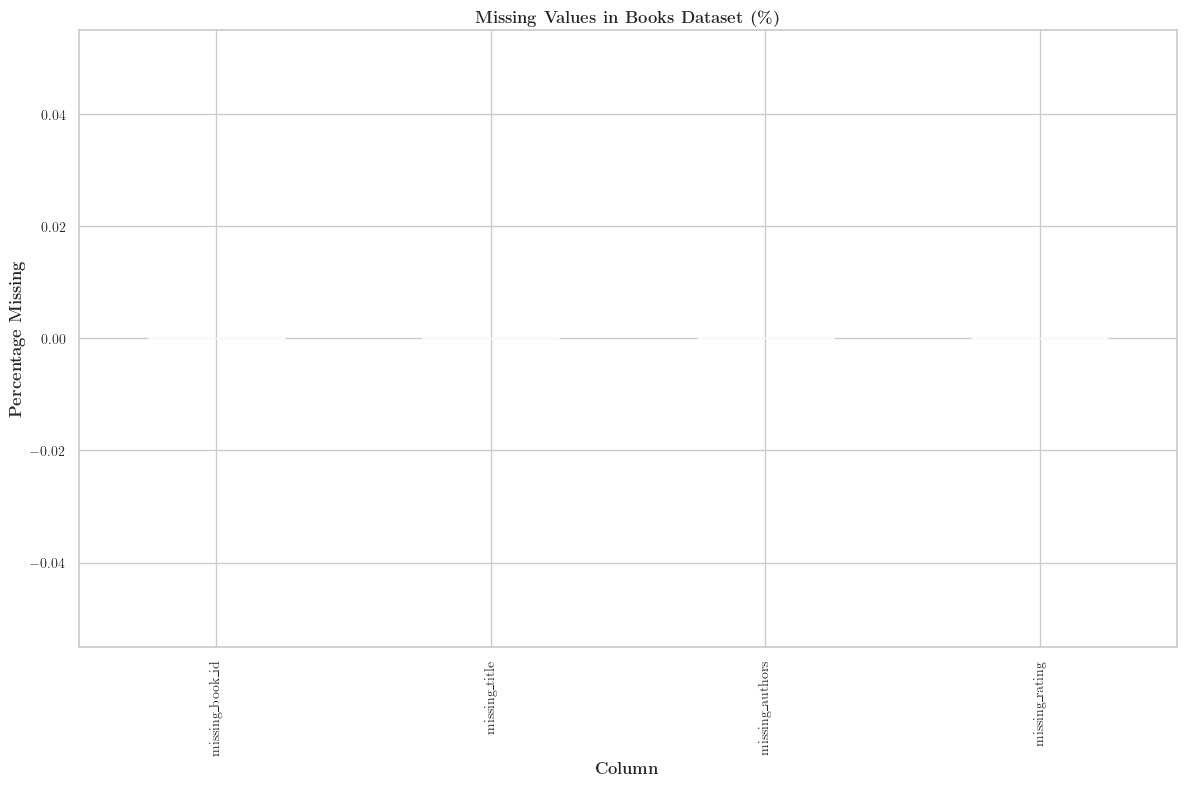

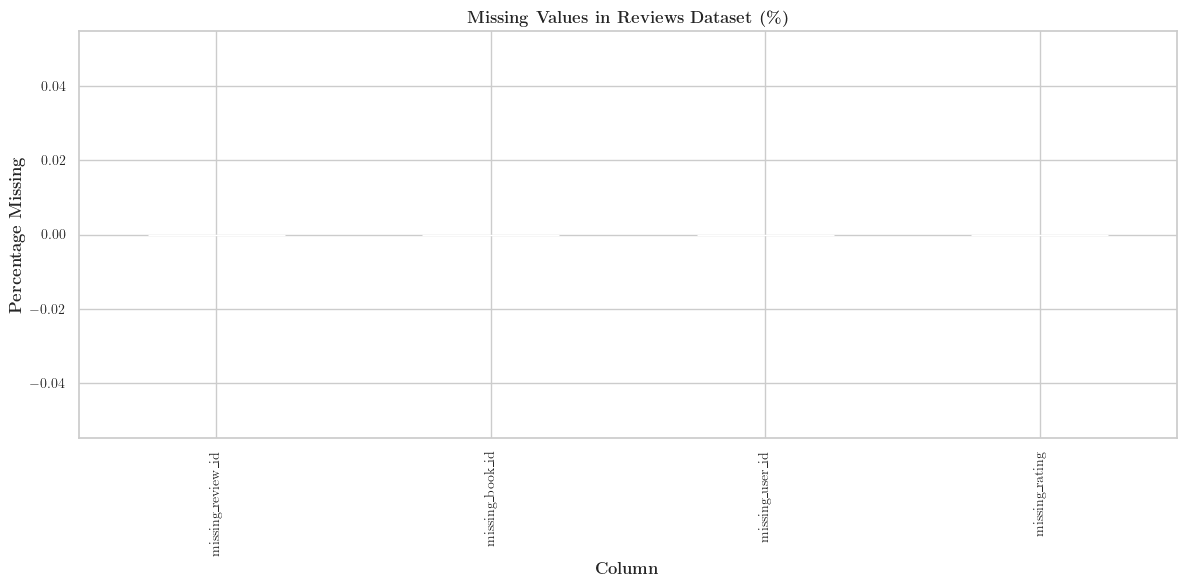

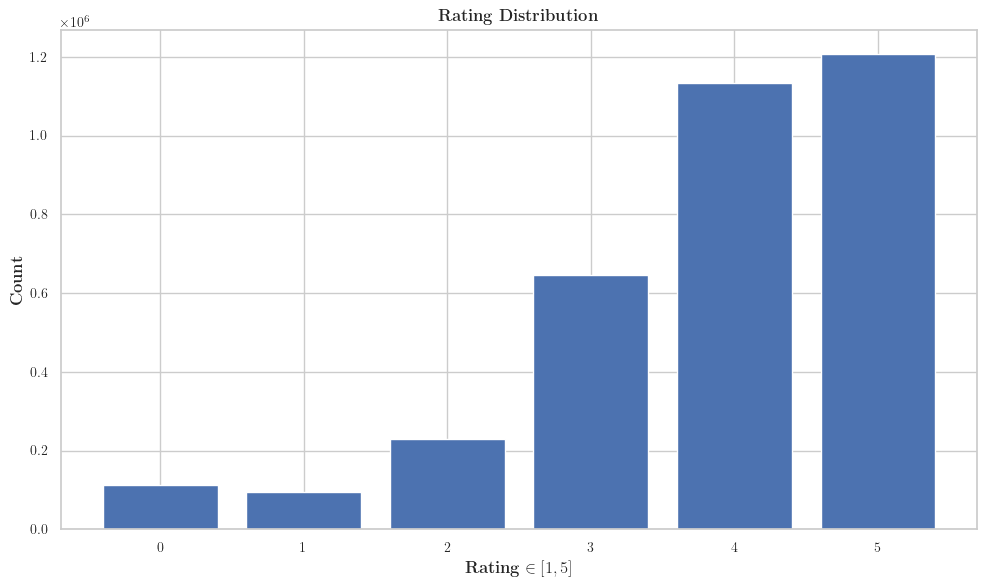

In [9]:
# Run dataset integrity analysis
integrity_results = dataset_integrity_analysis()

Performing user behavior profiling (optimized version)
Creating temporary indexes for performance...
Indexes created
Getting basic user statistics...
Found 256,088 total users
Calculating user activity distribution...
User segments plot created
Analyzing rating distribution (sampled)...
Rating distribution plot created
Analyzing temporal patterns (monthly aggregated)...
Temporal pattern plot created
Calculating reading frequency metrics...
Removing temporary indexes...
Temporary indexes removed

User Behavior Profiling Summary (completed in 113.3 seconds):
Total users: 256,088
Average reviews per user: 13.37
Average books per month: 13.35

User Segments:
  Super Active (100+ reviews): 5,949 users
  Very Active (50-99 reviews): 8,667 users
  Active (20-49 reviews): 22,200 users
  Regular (10-19 reviews): 27,683 users
  Casual (5-9 reviews): 39,346 users
  Infrequent (1-4 reviews): 152,243 users


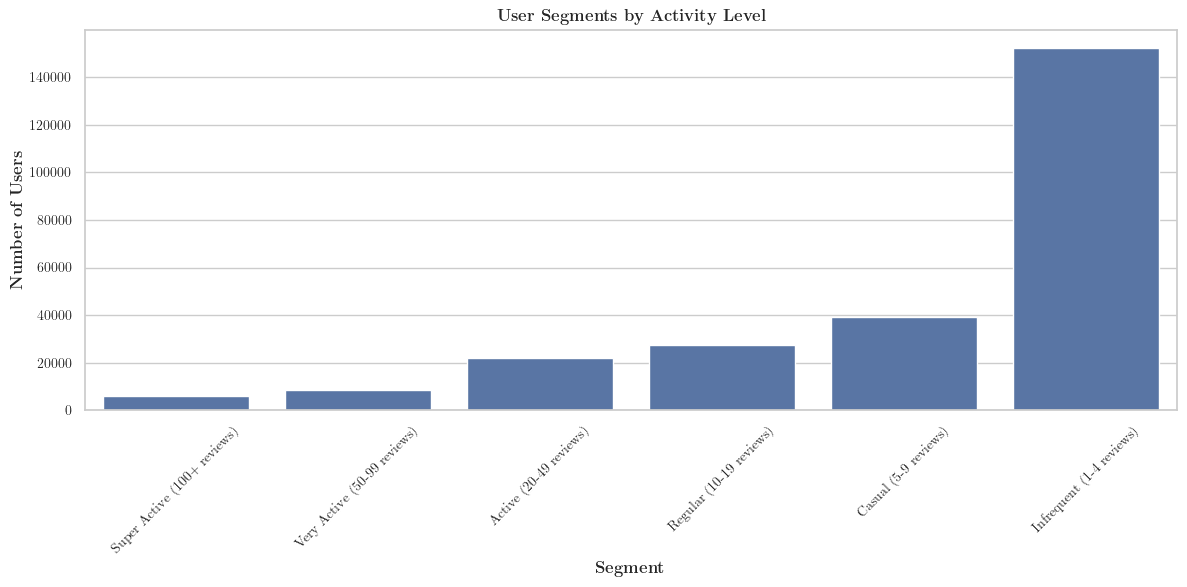

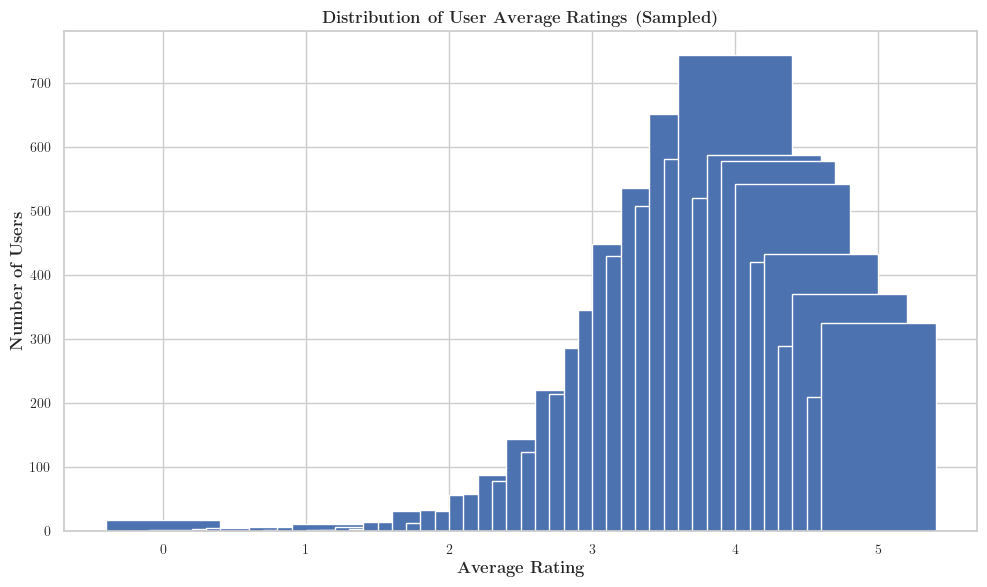

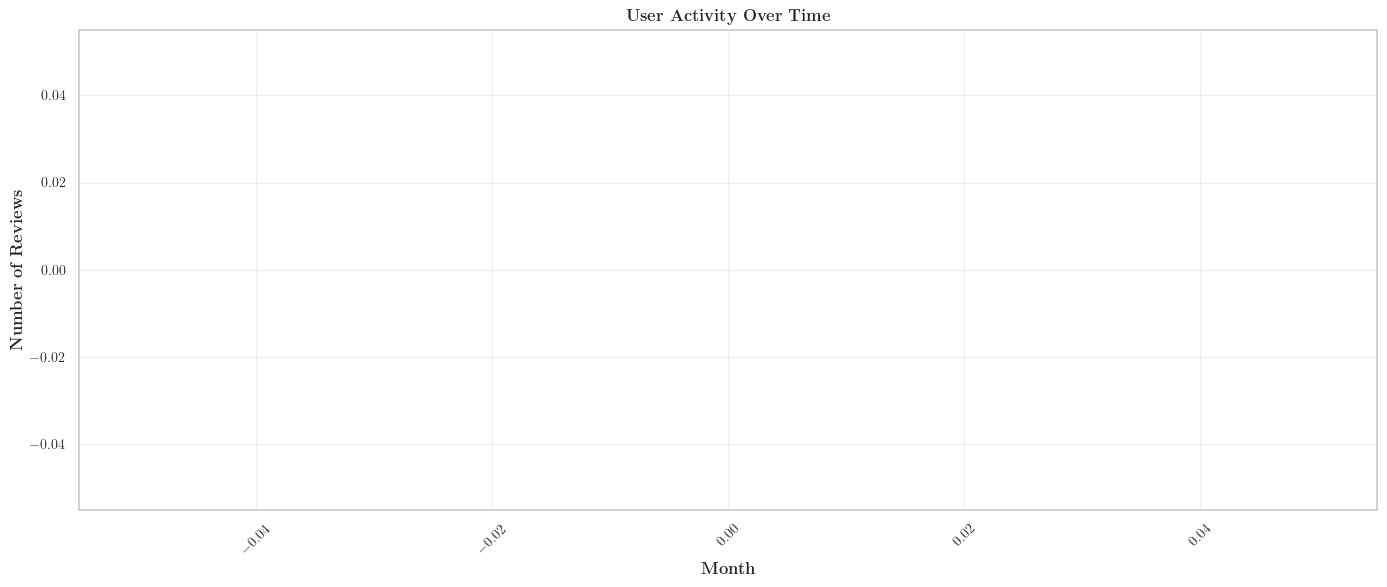

In [10]:
# Run user behavior profiling
user_behavior_results = user_behavior_profiling()

Performing content landscape mapping


2025-04-27 00:18:35,389 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-27 00:18:35,390 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Content Landscape Summary:
Total books: 258,585
Average rating: 3.94

Publication Year Validity:
  Before 1800: 62,563 books
  Future: 47 books
  Valid: 195,975 books

Top Rated Books:
  Make My World Spin by [{"author_id": "15608562", "role": ""}] - 5.00 (5 ratings)
  Witch Wars (The Underlayes, #1) by [{"author_id": "14851642", "role": ""}] - 5.00 (11 ratings)
  The Secret World of Alex Mack/Party of Five Claudia/Full House/Are You Afraid of the Dark by [{"author_id": "9339", "role": ""}] - 5.00 (2 ratings)
  The Diminished by [{"author_id": "15236270", "role": ""}] - 5.00 (9 ratings)
  Redemption by [{"author_id": "5316256", "role": ""}] - 5.00 (5 ratings)
  Amazing Grace (Unveiled #1.5) by [{"author_id": "8034382", "role": ""}] - 5.00 (4 ratings)
  Keos (Fueled By Lust #10) by [{"author_id": "7389067", "role": ""}] - 5.00 (5 ratings)
  Apex Magazine Issue 32 (January 2012) by [{"author_id": "2897358", "role": "Editor"}, {"author_id": "172490", "role": ""}, {"author_id": "194172", 

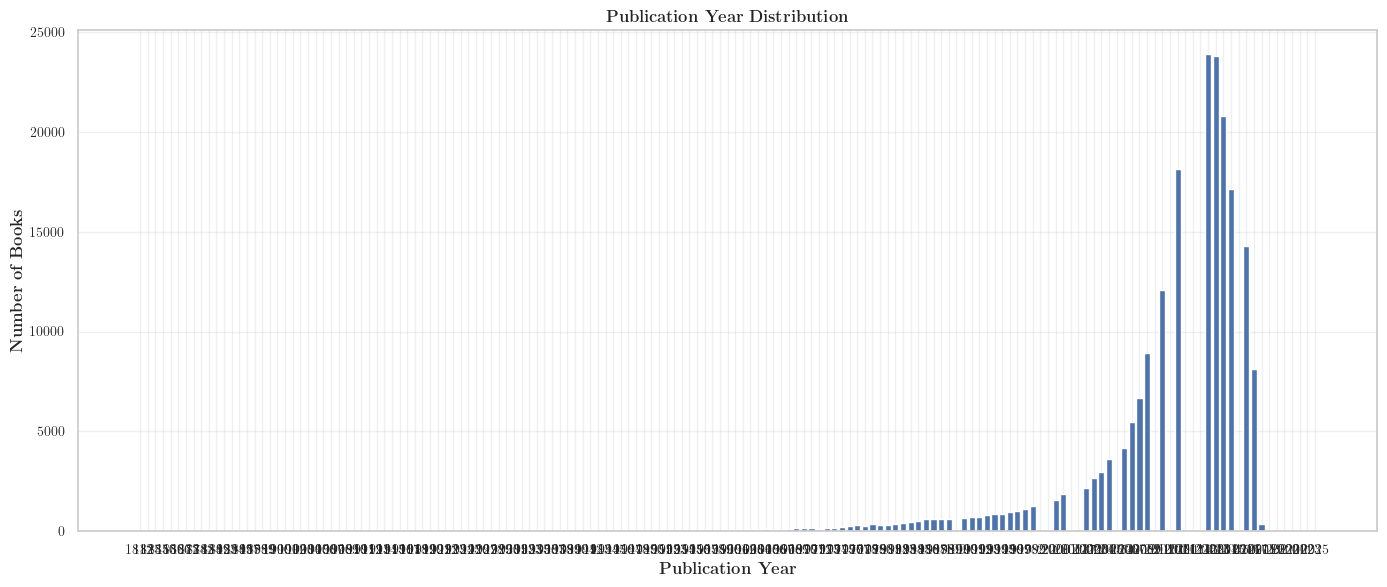

In [11]:
# Run content landscape mapping
content_landscape_results = content_landscape_mapping()

Generating reading pattern fingerprints


Processing users: 100%|██████████| 64499/64499 [02:08<00:00, 503.08it/s]


Generated reading pattern fingerprints for 64499 users


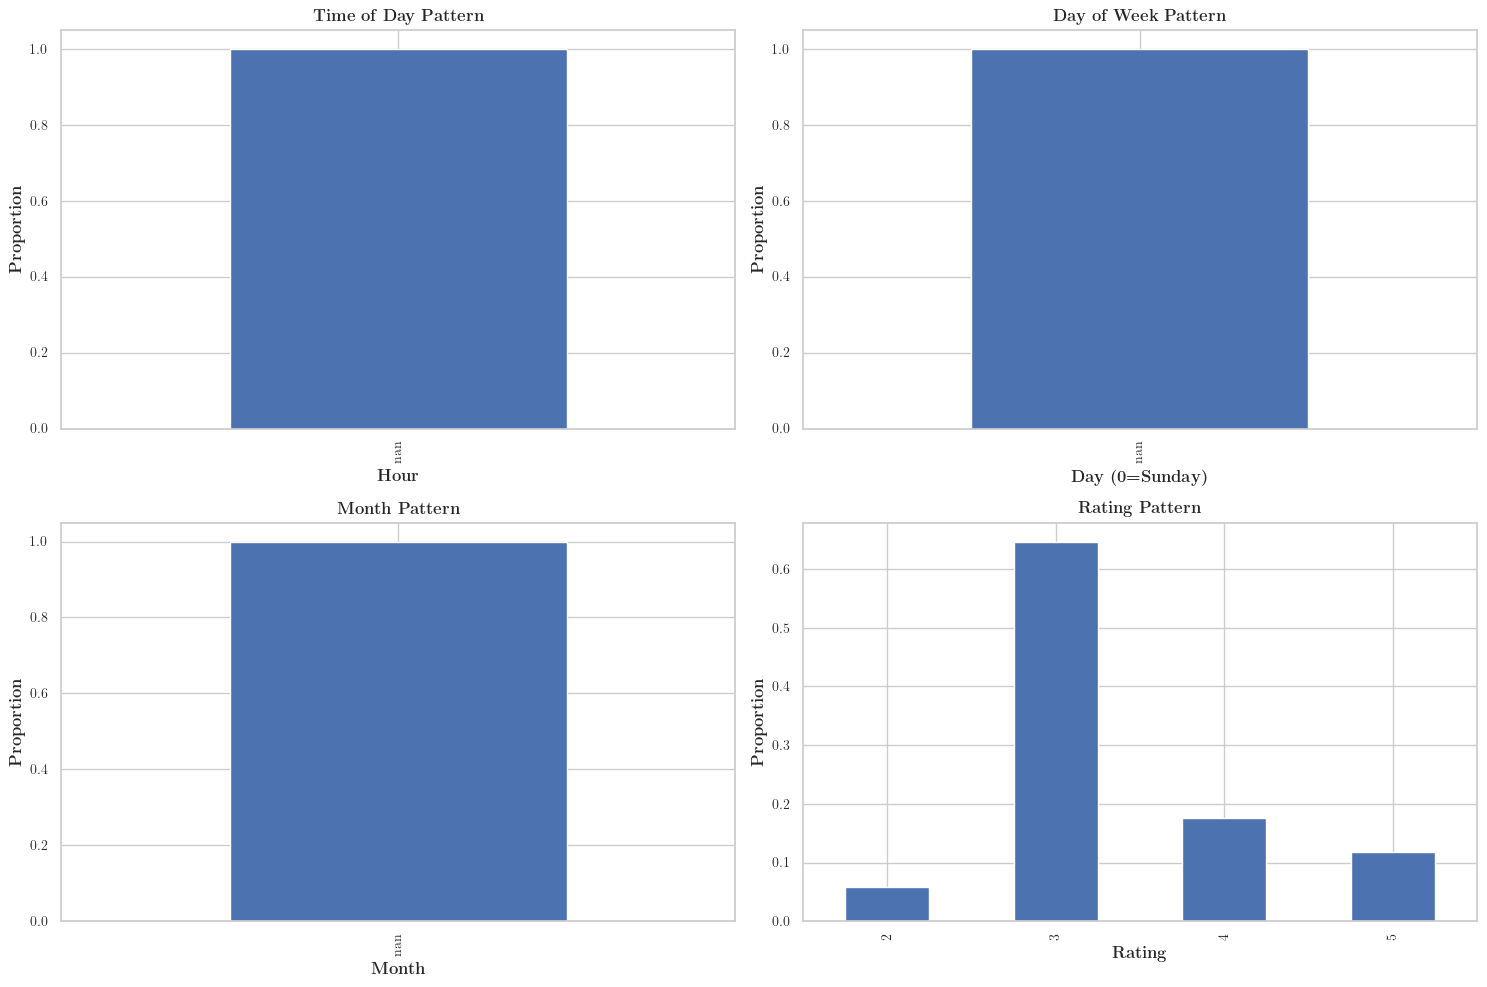

In [12]:
# Generate reading pattern fingerprints
reading_fingerprints = generate_reading_pattern_fingerprints(min_interactions=10)

No date-time info in dataset, but need to look deeper into user rating biases.

# User Behaviour deeper analysis

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def generate_rating_bias_fingerprints(min_ratings=5):
    """
    Calculate user rating bias fingerprints for all users with optimization.
    Uses the entire dataset but with efficient queries.

    Args:
        min_ratings: Minimum number of ratings a user must have (default: 5)
    """
    import time
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import sqlite3
    from tqdm import tqdm

    start_time = time.time()
    print("Starting rating bias analysis on full dataset...")

    # Connect to the database
    try:
        conn = connect_to_db()
        # First check if index exists on user_id, if not create it
        # This will dramatically speed up queries that filter by user_id
        cursor = conn.cursor()
        cursor.execute(
            "SELECT name FROM sqlite_master WHERE type='index' AND name='idx_reviews_user_id'"
        )
        if not cursor.fetchone():
            print(
                "Creating index on user_id (one-time operation, may take a minute)..."
            )
            cursor.execute("CREATE INDEX idx_reviews_user_id ON reviews(user_id)")
            conn.commit()

        cursor.execute(
            "SELECT name FROM sqlite_master WHERE type='index' AND name='idx_reviews_rating'"
        )
        if not cursor.fetchone():
            print("Creating index on rating (one-time operation, may take a minute)...")
            cursor.execute("CREATE INDEX idx_reviews_rating ON reviews(rating)")
            conn.commit()
    except Exception as e:
        print(f"Failed to connect to database or create index: {e}")
        return None

    # Step 1: Calculate global average rating
    print("Step 1/4: Calculating global average...")
    try:
        global_avg_query = """
        SELECT AVG(rating) FROM reviews WHERE rating IS NOT NULL
        """
        global_avg = pd.read_sql_query(global_avg_query, conn).iloc[0, 0]
        print(f"Global average rating: {global_avg:.2f}")
    except Exception as e:
        print(f"Error calculating global average: {e}")
        conn.close()
        return None

    # Step 2: Find eligible users (with min_ratings)
    print(f"Step 2/4: Finding users with at least {min_ratings} ratings...")
    try:
        eligible_users_query = f"""
        SELECT user_id, COUNT(*) as rating_count
        FROM reviews
        WHERE rating IS NOT NULL
        GROUP BY user_id
        HAVING COUNT(*) >= {min_ratings}
        """
        eligible_users_df = pd.read_sql_query(eligible_users_query, conn)
        user_count = len(eligible_users_df)

        if user_count == 0:
            print("No users found with specified criteria.")
            conn.close()
            return None

        print(f"Found {user_count} eligible users")
    except Exception as e:
        print(f"Error finding eligible users: {e}")
        conn.close()
        return None

    # Step 3: Calculate user bias metrics in chunks
    # Process in chunks to avoid memory issues
    print("Step 3/4: Calculating bias metrics...")

    # Optimize by using a single efficient query for all metrics
    try:
        # This single query calculates all necessary metrics in one go
        # significantly reducing the processing time
        bias_query = f"""
        WITH user_ratings AS (
            SELECT 
                user_id,
                AVG(rating) as avg_rating,
                COUNT(*) as rating_count,
                MIN(rating) as min_rating,
                MAX(rating) as max_rating
            FROM reviews
            WHERE rating IS NOT NULL
            GROUP BY user_id
            HAVING COUNT(*) >= {min_ratings}
        )
        SELECT 
            u.*,
            (u.avg_rating - {global_avg}) as rating_bias
        FROM user_ratings u
        """

        # Stream results to avoid memory issues
        print("Running optimized query (this may take a minute)...")
        bias_profiles = pd.read_sql_query(bias_query, conn)
        print(f"Retrieved bias data for {len(bias_profiles)} users")
    except Exception as e:
        print(f"Error calculating user bias metrics: {e}")
        conn.close()
        return None

    # Close connection
    conn.close()

    # Step 4: Post-processing and visualizations
    print("Step 4/4: Post-processing and creating visualizations...")

    # Rename columns for clarity
    bias_profiles = bias_profiles.rename(
        columns={"avg_rating": "user_avg_rating", "rating_bias": "avg_bias"}
    )

    # Add bias categories
    bias_profiles["bias_category"] = pd.cut(
        bias_profiles["avg_bias"],
        bins=[-float("inf"), -1.0, -0.5, 0.5, 1.0, float("inf")],
        labels=["Very Critical", "Critical", "Neutral", "Generous", "Very Generous"],
    )

    # Calculate additional derived metrics
    bias_profiles["rating_diversity"] = (
        bias_profiles["max_rating"] - bias_profiles["min_rating"]
    )

    # Generate visualizations

    # Distribution of average bias
    plt.figure(figsize=(12, 6))
    plt.hist(bias_profiles["avg_bias"], bins=50, color="skyblue", alpha=0.7)
    plt.axvline(0, color="red", linestyle="--", label="Global Average")
    plt.axvline(
        bias_profiles["avg_bias"].mean(),
        color="green",
        linestyle="-",
        label=f"Mean Bias: {bias_profiles['avg_bias'].mean():.2f}",
    )
    plt.xlabel("Rating Bias")
    plt.ylabel("Number of Users")
    plt.title("Distribution of User Rating Bias")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Distribution of bias categories
    plt.figure(figsize=(12, 6))
    sns.countplot(x="bias_category", data=bias_profiles, palette="viridis")
    plt.xlabel("Bias Category")
    plt.ylabel("Number of Users")
    plt.title("Distribution of Users by Bias Category")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Relationship between number of ratings and bias
    plt.figure(figsize=(12, 6))
    plt.scatter(
        bias_profiles["rating_count"],
        bias_profiles["avg_bias"],
        alpha=0.3,
        s=5,
        color="blue",
    )
    plt.axhline(0, color="red", linestyle="--")
    plt.xscale("log")
    plt.xlabel("Number of Ratings (log scale)")
    plt.ylabel("Rating Bias")
    plt.title("Relationship Between Number of Ratings and Rating Bias")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Relationship between average rating and bias
    plt.figure(figsize=(12, 6))
    plt.scatter(
        bias_profiles["user_avg_rating"],
        bias_profiles["avg_bias"],
        alpha=0.3,
        s=5,
        color="green",
    )
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("User Average Rating")
    plt.ylabel("Rating Bias")
    plt.title("Relationship Between Average Rating and Rating Bias")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Rating diversity distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(x="rating_diversity", data=bias_profiles, palette="plasma")
    plt.xlabel("Rating Diversity (max - min rating)")
    plt.ylabel("Number of Users")
    plt.title("Distribution of Rating Diversity")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    print(f"Analysis completed in {time.time() - start_time:.2f} seconds")
    print(f"Total number of users analyzed: {len(bias_profiles)}")

    return bias_profiles

def generate_rating_pattern_fingerprints(min_ratings=5, max_users=None):
    """
    Generate rating pattern fingerprints for ALL users with ultra-efficient processing.
    Performs deep analysis of how users distribute their ratings across the 1-5 scale.
    
    Args:
        min_ratings: Minimum number of ratings a user must have (default: 5)
        max_users: Optional limit on number of users to analyze (default: None = all users)
    """
    import sqlite3
    import time
    
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from scipy import stats
    from sklearn.cluster import KMeans, DBSCAN
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    start_time = time.time()
    print("Starting ultra-efficient rating pattern analysis on full dataset...")
    
    # Connect to the database and optimize with indexes
    try:
        conn = connect_to_db()
        cursor = conn.cursor()
        
        # Ensure all needed indexes exist for maximum performance
        indexes = {
            "idx_reviews_user_id": "CREATE INDEX idx_reviews_user_id ON reviews(user_id)",
            "idx_reviews_rating": "CREATE INDEX idx_reviews_rating ON reviews(rating)",
            "idx_reviews_book_id": "CREATE INDEX idx_reviews_book_id ON reviews(book_id)",
        }
        
        for idx_name, idx_sql in indexes.items():
            cursor.execute(f"SELECT name FROM sqlite_master WHERE type='index' AND name='{idx_name}'")
            if not cursor.fetchone():
                print(f"Creating index {idx_name} (one-time operation)...")
                cursor.execute(idx_sql)
                conn.commit()
                
        # Enable pragmas for faster queries
        cursor.execute("PRAGMA temp_store = MEMORY;")
        cursor.execute("PRAGMA cache_size = -50000;") # 50MB cache
        cursor.execute("PRAGMA journal_mode = WAL;")
        conn.commit()
    except Exception as e:
        print(f"Failed to connect to database or create index: {e}")
        return None
    
    # Step 1: Find eligible users with minimum rating count (optimized query)
    print(f"Step 1/6: Finding users with at least {min_ratings} ratings...")
    try:
        # Using COUNT(*) with GROUP BY is more efficient than subqueries for this use case
        eligible_users_query = f"""
        SELECT user_id, COUNT(*) as rating_count
        FROM reviews
        WHERE rating IS NOT NULL
        GROUP BY user_id
        HAVING COUNT(*) >= {min_ratings}
        """
        
        if max_users:
            eligible_users_query += f" ORDER BY rating_count DESC LIMIT {max_users}"
        
        # Use pandas with efficient chunksize for large results
        eligible_users_df = pd.read_sql_query(eligible_users_query, conn)
        user_count = len(eligible_users_df)
        
        if user_count == 0:
            print("No users found with specified criteria.")
            conn.close()
            return None
            
        print(f"Found {user_count:,} eligible users with {eligible_users_df['rating_count'].sum():,} total ratings")
        
        # Output user statistics
        print(f"  Min ratings per user: {eligible_users_df['rating_count'].min()}")
        print(f"  Max ratings per user: {eligible_users_df['rating_count'].max()}")
        print(f"  Median ratings per user: {eligible_users_df['rating_count'].median()}")
        print(f"  Mean ratings per user: {eligible_users_df['rating_count'].mean():.1f}")
    except Exception as e:
        print(f"Error finding eligible users: {e}")
        conn.close()
        return None
    
    # Step 2: Get rating distributions with a single efficient query
    print("Step 2/6: Retrieving rating patterns...")
    try:
        # Ultra-optimized query using Common Table Expression and direct GROUP BY
        patterns_query = f"""
        WITH eligible_users AS (
            SELECT user_id
            FROM reviews
            WHERE rating IS NOT NULL
            GROUP BY user_id
            HAVING COUNT(*) >= {min_ratings}
            {f'ORDER BY COUNT(*) DESC LIMIT {max_users}' if max_users else ''}
        )
        SELECT 
            r.user_id,
            r.rating,
            COUNT(*) as rating_count
        FROM reviews r
        JOIN eligible_users e ON r.user_id = e.user_id
        WHERE r.rating IS NOT NULL
        GROUP BY r.user_id, r.rating
        """
        
        print("Running optimized query...")
        start_query = time.time()
        rating_patterns_raw = pd.read_sql_query(patterns_query, conn)
        print(f"Query completed in {time.time() - start_query:.2f} seconds")
        
        # Process rating percentages efficiently with vectorized operations
        print("Calculating rating percentages...")
        user_totals = rating_patterns_raw.groupby('user_id')['rating_count'].sum().reset_index()
        user_totals.columns = ['user_id', 'total_ratings']
        
        # Merge with optimized parameters
        rating_patterns = pd.merge(rating_patterns_raw, user_totals, on='user_id', how='left')
        rating_patterns['rating_percentage'] = rating_patterns['rating_count'] / rating_patterns['total_ratings']
        
        unique_users = rating_patterns['user_id'].nunique()
        print(f"Retrieved {len(rating_patterns):,} rating patterns for {unique_users:,} users")
    except Exception as e:
        print(f"Error retrieving rating patterns: {e}")
        conn.close()
        return None
    
    # Close database connection
    conn.close()
    
    # Step 3: Create user fingerprints (optimized pivot)
    print("Step 3/6: Creating fingerprints...")
    try:
        # Pivot to create user fingerprints (memory optimized)
        pattern_matrix = rating_patterns.pivot(
            index='user_id', columns='rating', values='rating_percentage'
        ).fillna(0)
        
        # Ensure all ratings 1-5 exist
        for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
            if rating not in pattern_matrix.columns:
                pattern_matrix[rating] = 0
                
        # Reorder columns for consistency
        pattern_matrix = pattern_matrix.reindex(columns=[1.0, 2.0, 3.0, 4.0, 5.0])
                
        print(f"Created fingerprints matrix with shape: {pattern_matrix.shape}")
    except Exception as e:
        print(f"Error creating fingerprints: {e}")
        return None
    
    # Step 4: Calculate comprehensive metrics
    print("Step 4/6: Calculating advanced metrics...")
    try:
        # Initialize results DataFrame
        metrics = pd.DataFrame(index=pattern_matrix.index)
        
        # Basic metrics
        metrics['primary_rating'] = pattern_matrix.idxmax(axis=1)
        metrics['primary_rating_pct'] = pattern_matrix.max(axis=1)
        
        # Entropy metric (rating diversity)
        epsilon = 1e-10
        log_vals = np.log(pattern_matrix.clip(lower=epsilon))
        entropy_values = -(pattern_matrix * log_vals).sum(axis=1)
        metrics['rating_entropy'] = entropy_values
        
        # Rating bias metrics
        metrics['high_rating_bias'] = pattern_matrix[4.0] + pattern_matrix[5.0]
        metrics['low_rating_bias'] = pattern_matrix[1.0] + pattern_matrix[2.0]
        metrics['rating_skew'] = metrics['high_rating_bias'] - metrics['low_rating_bias']
        
        # New metrics
        # Gini coefficient (measure of inequality in rating distribution)
        def gini(x):
            # Assumes x is already sorted
            n = len(x)
            s = x.sum()
            if s == 0 or n <= 1:
                return 0
            # Normalized Gini calculation
            return (n + 1 - 2 * np.sum((n + 1 - np.arange(1, n+1)) * x / s)) / n
        
        # Apply gini to each user's rating distribution
        metrics['rating_gini'] = pattern_matrix.apply(lambda x: gini(x.sort_values()), axis=1)
        
        # Rating volatility (standard deviation of rating distribution)
        rating_values = np.array([1, 2, 3, 4, 5])
        
        def weighted_std(x):
            # Calculate weighted standard deviation of ratings
            weights = np.array([x[1.0], x[2.0], x[3.0], x[4.0], x[5.0]])
            if sum(weights) == 0:
                return 0
            avg = sum(weights * rating_values) / sum(weights)
            variance = sum(weights * (rating_values - avg)**2) / sum(weights)
            return np.sqrt(variance)
        
        metrics['rating_volatility'] = pattern_matrix.apply(weighted_std, axis=1)
        
        # Rating extremity (preference for extreme ratings vs middle ratings)
        metrics['rating_extremity'] = (pattern_matrix[1.0] + pattern_matrix[5.0]) - pattern_matrix[3.0]
        
        # Add rating count from user_totals
        metrics = pd.merge(metrics.reset_index(), user_totals, on='user_id').set_index('user_id')
        
        # Categorize users by primary rating
        metrics['primary_rating_category'] = metrics['primary_rating'].map({
            1.0: 'Very Negative',
            2.0: 'Negative',
            3.0: 'Neutral',
            4.0: 'Positive',
            5.0: 'Very Positive'
        })
        
        # Categorize rating entropy
        metrics['entropy_category'] = pd.qcut(
            metrics['rating_entropy'], 
            q=5, 
            labels=['Very Focused', 'Focused', 'Moderate', 'Diverse', 'Very Diverse']
        )
        
        # Combine with pattern matrix for final fingerprints
        fingerprints = pd.merge(
            pattern_matrix.reset_index(),
            metrics.reset_index(),
            on='user_id'
        )
        
        print(f"Calculated {len(metrics.columns)} metrics for {len(fingerprints):,} users")
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return None
    
    # Step 5: Advanced clustering and dimensionality reduction
    print("Step 5/6: Performing advanced pattern analysis...")
    
    try:
        # Use only the rating pattern columns for analysis
        pattern_cols = [1.0, 2.0, 3.0, 4.0, 5.0]
        X = pattern_matrix[pattern_cols].values
        
        # Scale the data for better clustering
        scaler = StandardScaler()
        scaled_patterns = scaler.fit_transform(X)
        
        # PCA for dimensionality reduction and visualization
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_patterns)
        print(f"PCA variance explained: {sum(pca.explained_variance_ratio_):.1%}")
        
        # Add PCA results to fingerprints
        fingerprints['pca_x'] = pca_result[:, 0]
        fingerprints['pca_y'] = pca_result[:, 1]
        
        # Get optimal number of clusters using simplified silhouette analysis
        # (simplified for speed - normally would use silhouette scores)
        k = 5  # Use fixed k=5 for efficiency
        
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(scaled_patterns)
        
        # Calculate silhouette score for the clustering
        from sklearn.metrics import silhouette_score
        try:
            sil_score = silhouette_score(scaled_patterns, clusters)
            print(f"K-means silhouette score: {sil_score:.3f}")
        except:
            print("Couldn't calculate silhouette score")
        
        # Add cluster information to results
        fingerprints['cluster'] = clusters
        
        # Alternative clustering with DBSCAN for outlier detection
        # Only if dataset is not too large
        if len(pattern_matrix) < 50000:
            try:
                print("Performing DBSCAN clustering for outlier detection...")
                dbscan = DBSCAN(eps=0.5, min_samples=10)
                dbscan_clusters = dbscan.fit_predict(scaled_patterns)
                
                # Add DBSCAN results
                fingerprints['dbscan_cluster'] = dbscan_clusters
                outliers = (dbscan_clusters == -1).sum()
                print(f"DBSCAN found {outliers} outliers ({outliers/len(fingerprints):.1%})")
            except Exception as e:
                print(f"Skipping DBSCAN: {e}")
        
        print(f"Advanced pattern analysis complete")
    except Exception as e:
        print(f"Error during advanced pattern analysis: {e}")
        print("Continuing without advanced pattern analysis")
    
    # Step 6: Generate comprehensive visualizations
    print("Step 6/6: Generating visualizations...")
    
    # 1. Primary rating distribution
    plt.figure(figsize=(12, 7))
    primary_counts = metrics['primary_rating'].value_counts().sort_index()
    ax = sns.barplot(x=primary_counts.index, y=primary_counts.values, palette='viridis')
    
    # Add percentage labels on bars
    total = primary_counts.sum()
    for i, count in enumerate(primary_counts):
        ax.text(i, count + 0.1, f"{count/total:.1%}", ha='center')
        
    plt.xlabel("Primary Rating")
    plt.ylabel("Number of Users")
    plt.title("Distribution of Users by Primary Rating")
    plt.xticks(range(len(primary_counts)), [int(x) for x in primary_counts.index])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # 2. Rating entropy distribution with annotations
    plt.figure(figsize=(12, 7))
    sns.histplot(metrics['rating_entropy'], bins=50, kde=True)
    
    # Add vertical lines for quantiles
    quantiles = metrics['rating_entropy'].quantile([0.25, 0.5, 0.75])
    for q, qval in quantiles.items():
        plt.axvline(qval, color=['green', 'red', 'blue'][int(q*4)-1], 
                   linestyle='--', label=f"{int(q*100)}%: {qval:.2f}")
    
    plt.xlabel("Rating Entropy")
    plt.ylabel("Number of Users")
    plt.title("Distribution of Rating Entropy (Higher = More Diverse Ratings)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # 3. Average rating patterns with standard error
    plt.figure(figsize=(12, 7))
    avg_pattern = pattern_matrix.mean()
    std_pattern = pattern_matrix.std() / np.sqrt(len(pattern_matrix))  # Standard error
    
    x = np.arange(len(avg_pattern))
    plt.bar(x, avg_pattern, yerr=std_pattern, capsize=10, color='skyblue', alpha=0.7)
    
    # Add percentage labels on bars
    for i, v in enumerate(avg_pattern):
        plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
    
    plt.xlabel("Rating")
    plt.ylabel("Average Percentage")
    plt.title("Average Rating Distribution Across All Users")
    plt.xticks(x, [int(x) for x in avg_pattern.index])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # 4. Rating skew distribution
    plt.figure(figsize=(12, 7))
    sns.histplot(metrics['rating_skew'], bins=50, kde=True)
    plt.axvline(0, color='red', linestyle='--', label='Neutral')
    plt.axvline(metrics['rating_skew'].mean(), color='green', linestyle='-', 
               label=f"Mean: {metrics['rating_skew'].mean():.2f}")
    plt.xlabel("Rating Skew (High - Low Ratings)")
    plt.ylabel("Number of Users")
    plt.title("Distribution of Rating Skew (Positive = More High Ratings)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # 5. New plot: Rating patterns by cluster
    plt.figure(figsize=(15, 10))
    
    # Get average pattern for each cluster
    cluster_centers = pd.DataFrame(
        kmeans.cluster_centers_, 
        columns=pattern_matrix.columns
    )
    
    # Plot each cluster's average pattern
    for i in range(k):
        plt.subplot(2, 3, i+1)
        cluster_size = sum(fingerprints['cluster'] == i)
        plt.bar(range(1, 6), cluster_centers.iloc[i], color=f'C{i}', alpha=0.7)
        plt.title(f'Cluster {i+1} (n={cluster_size}, {cluster_size/len(fingerprints):.1%})')
        plt.xlabel('Rating')
        plt.ylabel('Percentage')
        plt.ylim(0, max(1.0, cluster_centers.values.max() + 0.1))
        plt.xticks(range(1, 6))
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Rating Patterns by Cluster', fontsize=16, y=1.02)
    plt.show()
    
    # 6. New plot: PCA visualization of rating patterns
    plt.figure(figsize=(12, 10))
    
    # Create colormap based on primary rating
    plt.scatter(
        fingerprints['pca_x'], 
        fingerprints['pca_y'],
        c=fingerprints['primary_rating'],
        cmap='viridis',
        alpha=0.5,
        s=5
    )
    
    plt.colorbar(label='Primary Rating')
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    plt.title('PCA of User Rating Patterns')
    plt.grid(alpha=0.3)
    plt.show()
    
    # 7. New plot: Rating Gini coefficient distribution
    plt.figure(figsize=(12, 7))
    sns.histplot(metrics['rating_gini'], bins=50, kde=True)
    plt.axvline(metrics['rating_gini'].mean(), color='red', linestyle='--', 
               label=f"Mean: {metrics['rating_gini'].mean():.3f}")
    plt.axvline(metrics['rating_gini'].median(), color='green', linestyle='-', 
               label=f"Median: {metrics['rating_gini'].median():.3f}")
    plt.xlabel("Rating Gini Coefficient")
    plt.ylabel("Number of Users")
    plt.title("Distribution of Rating Inequality (Higher = More Unequal Distribution)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # 8. New plot: Rating Extremity vs. Entropy
    plt.figure(figsize=(12, 7))
    plt.scatter(
        metrics['rating_extremity'], 
        metrics['rating_entropy'],
        alpha=0.3,
        s=5
    )
    plt.xlabel("Rating Extremity (Extreme - Middle)")
    plt.ylabel("Rating Entropy")
    plt.title("Relationship Between Rating Extremity and Diversity")
    plt.grid(True, alpha=0.3)
    
    # Add a best fit line
    try:
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            metrics['rating_extremity'], 
            metrics['rating_entropy']
        )
        x = np.linspace(
            metrics['rating_extremity'].min(), 
            metrics['rating_extremity'].max(), 
            100
        )
        plt.plot(x, intercept + slope*x, 'r-', 
                label=f'r = {r_value:.2f}, p = {p_value:.3g}')
        plt.legend()
    except:
        pass
        
    plt.show()
    
    # Final timing info
    print(f"Analysis completed in {time.time() - start_time:.2f} seconds")
    print(f"Total number of users analyzed: {len(fingerprints):,}")
    
    return fingerprints  



Starting rating bias analysis on full dataset...
Step 1/4: Calculating global average...
Global average rating: 3.82
Step 2/4: Finding users with at least 5 ratings...
Found 103845 eligible users
Step 3/4: Calculating bias metrics...
Running optimized query (this may take a minute)...
Retrieved bias data for 103845 users
Step 4/4: Post-processing and creating visualizations...


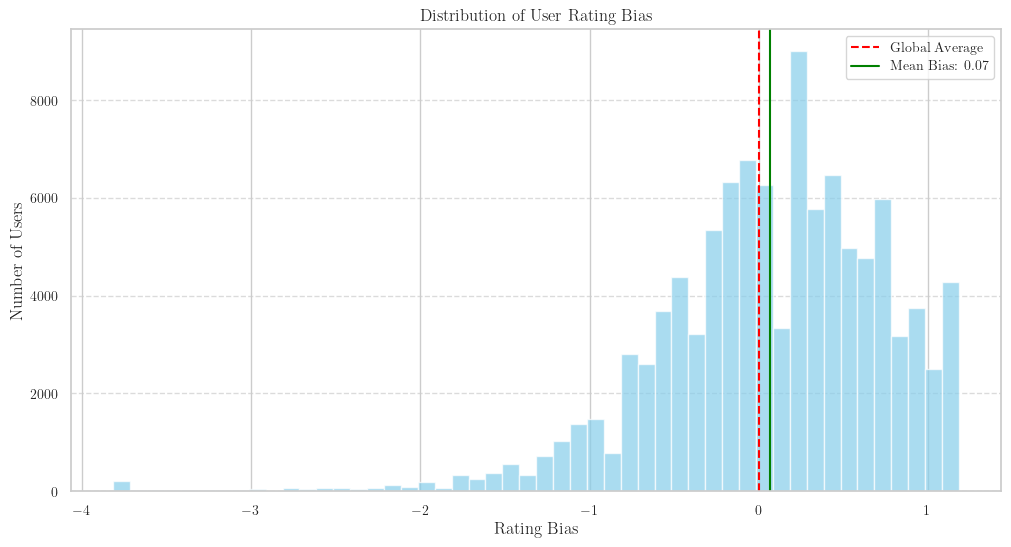

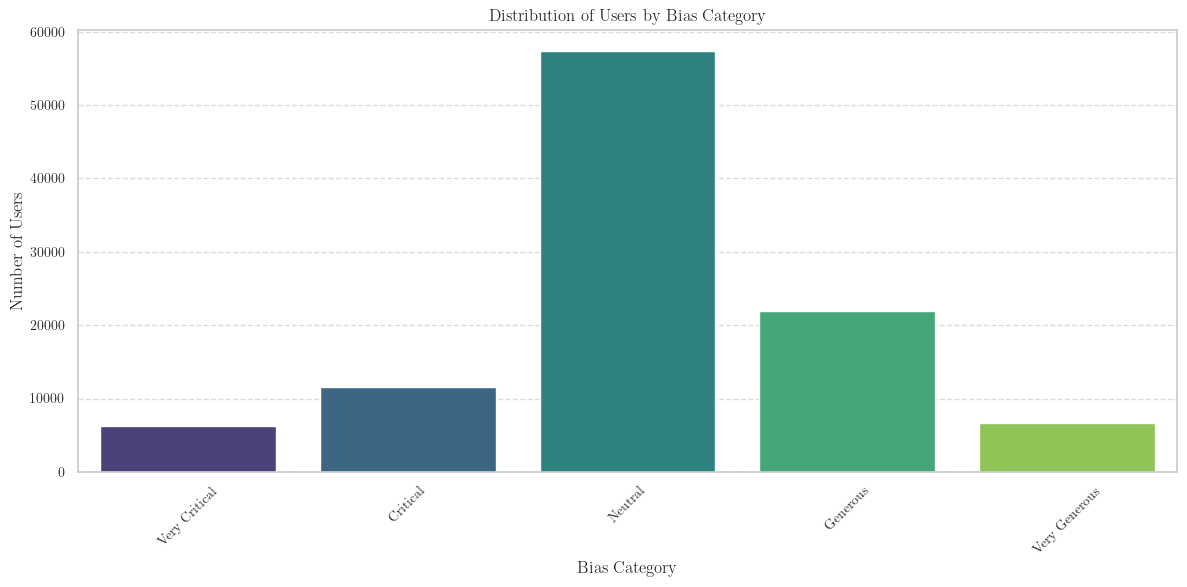

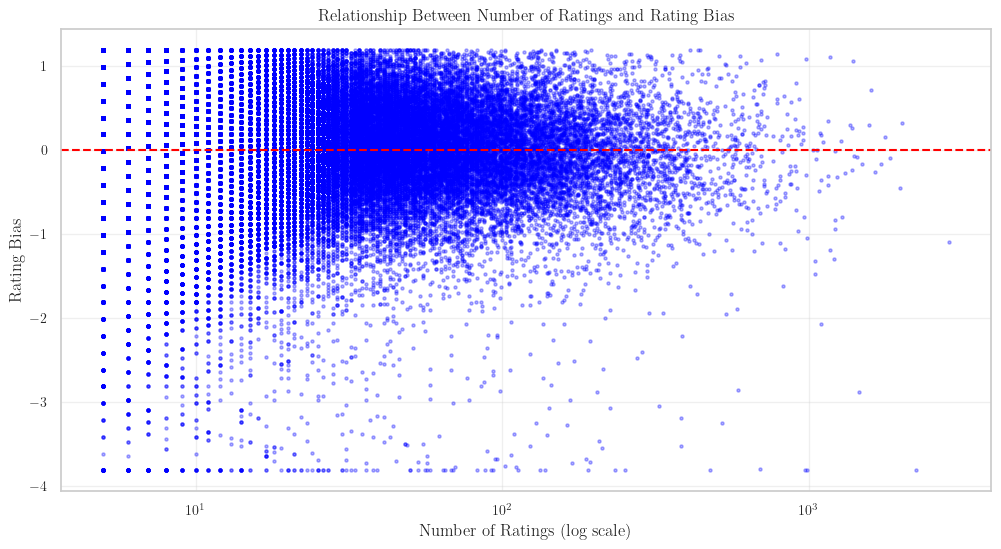

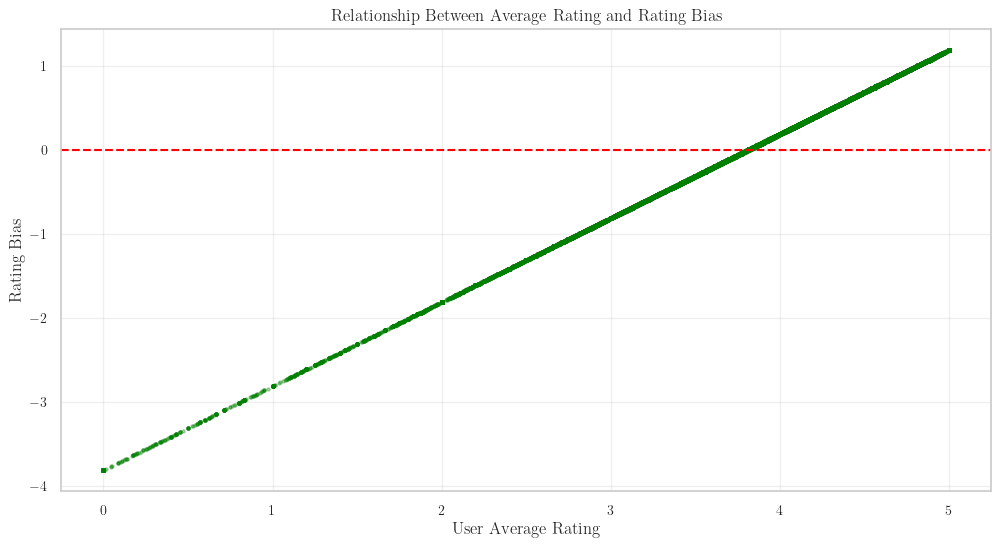

2025-04-27 00:24:38,394 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-27 00:24:38,431 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


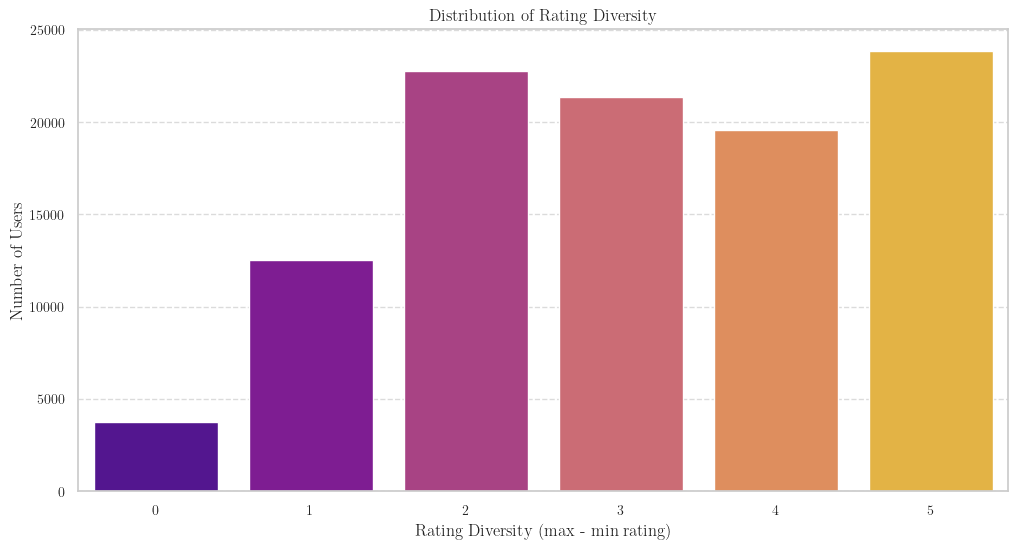

Analysis completed in 232.73 seconds
Total number of users analyzed: 103845


In [14]:
# Generate rating bias fingerprints
bias_profiles = generate_rating_bias_fingerprints()



Starting ultra-efficient rating pattern analysis on full dataset...
Step 1/6: Finding users with at least 5 ratings...
Found 103,845 eligible users with 3,144,782 total ratings
  Min ratings per user: 5
  Max ratings per user: 2868
  Median ratings per user: 13.0
  Mean ratings per user: 30.3
Step 2/6: Retrieving rating patterns...
Running optimized query...
Query completed in 106.55 seconds
Calculating rating percentages...
Retrieved 376,808 rating patterns for 103,845 users
Step 3/6: Creating fingerprints...
Created fingerprints matrix with shape: (103845, 5)
Step 4/6: Calculating advanced metrics...
Calculated 12 metrics for 103,845 users
Step 5/6: Performing advanced pattern analysis...
PCA variance explained: 67.3%


2025-04-27 00:31:05,642 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-27 00:31:05,648 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


K-means silhouette score: 0.290
Advanced pattern analysis complete
Step 6/6: Generating visualizations...


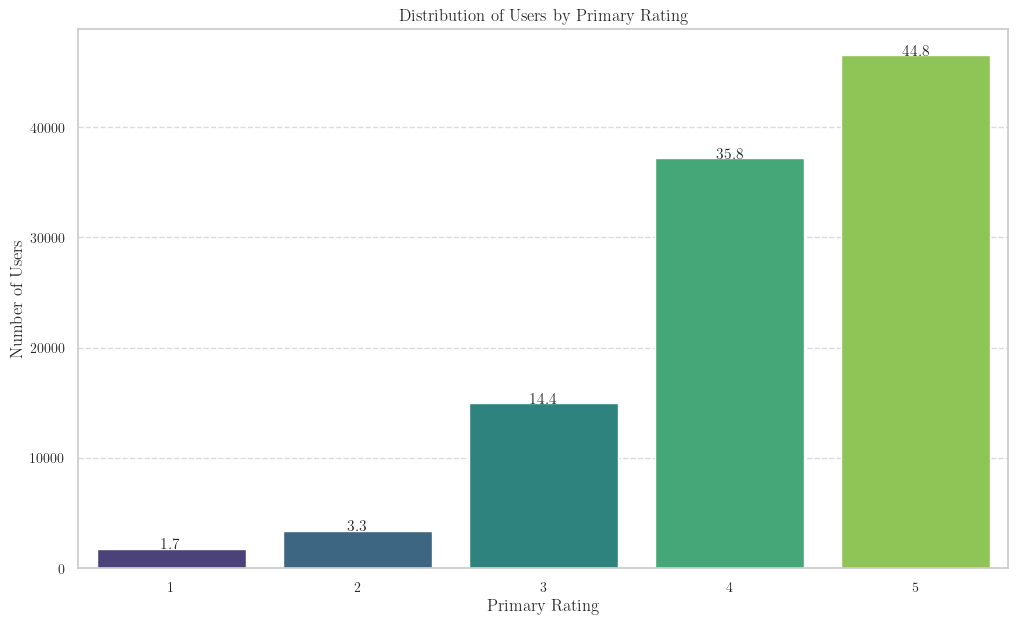

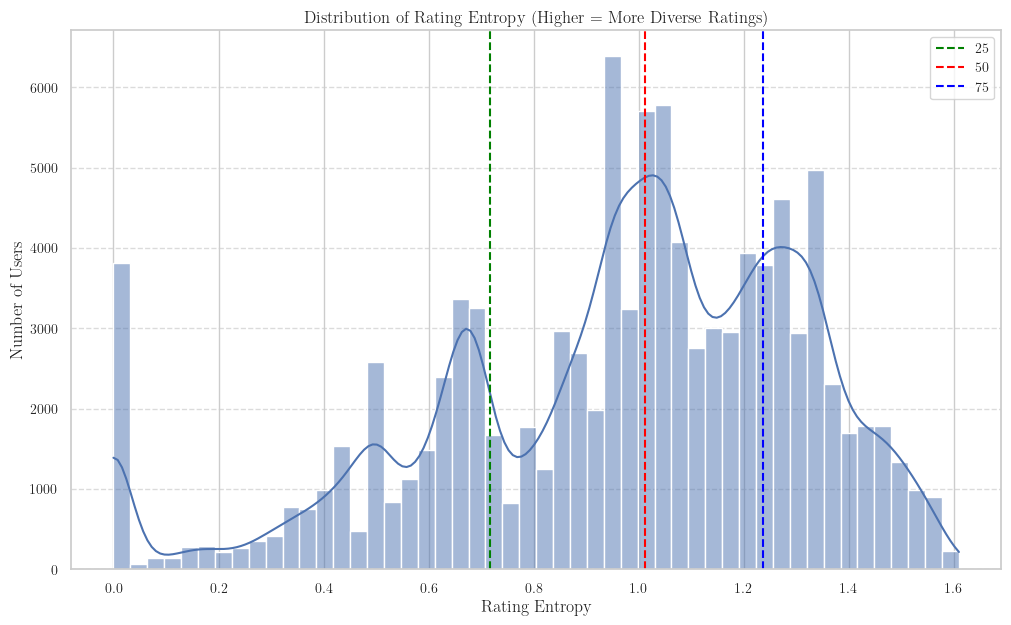

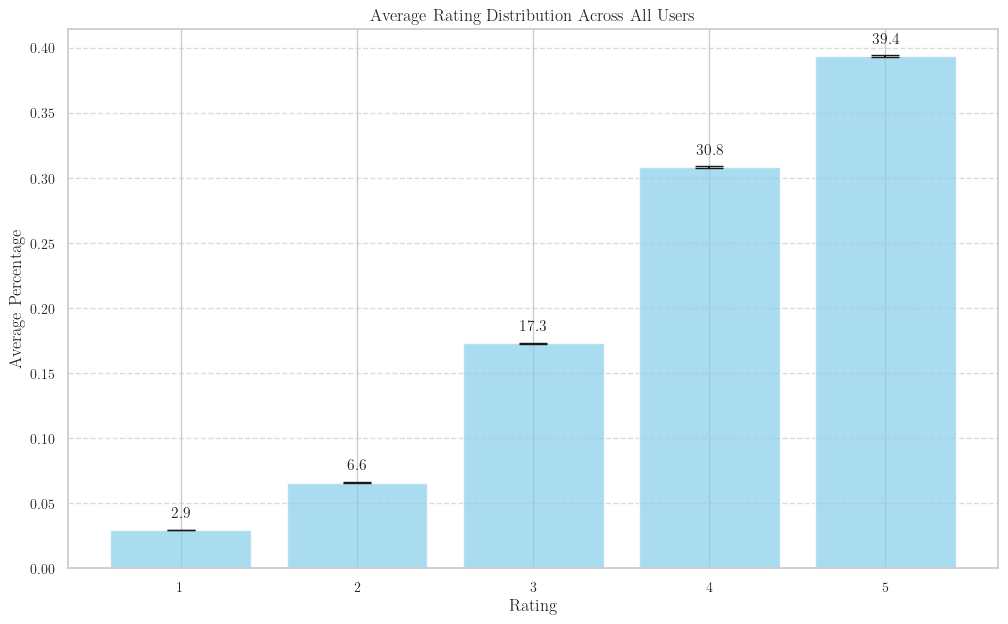

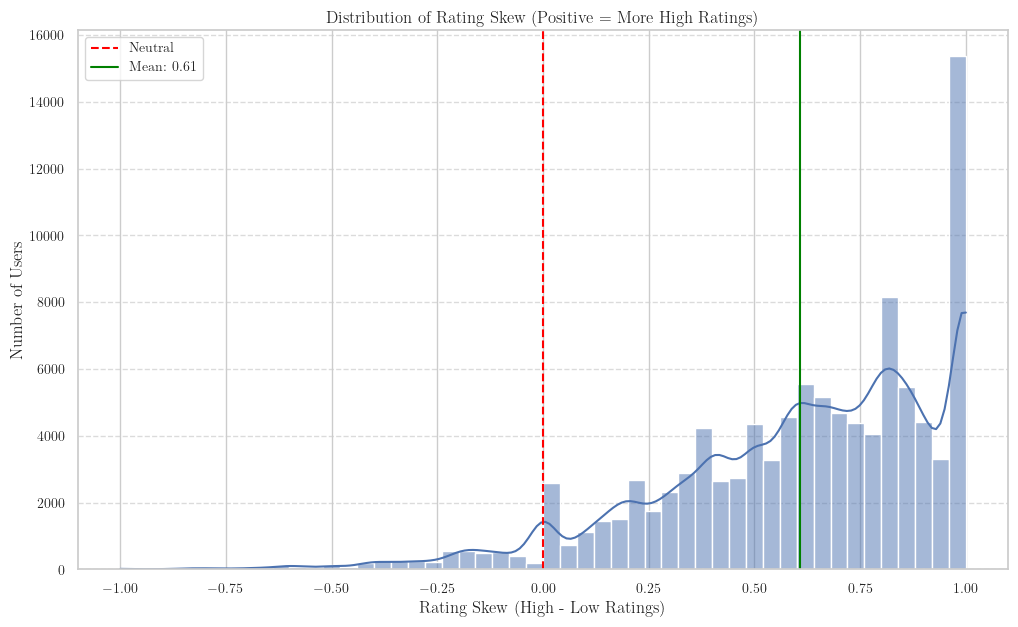

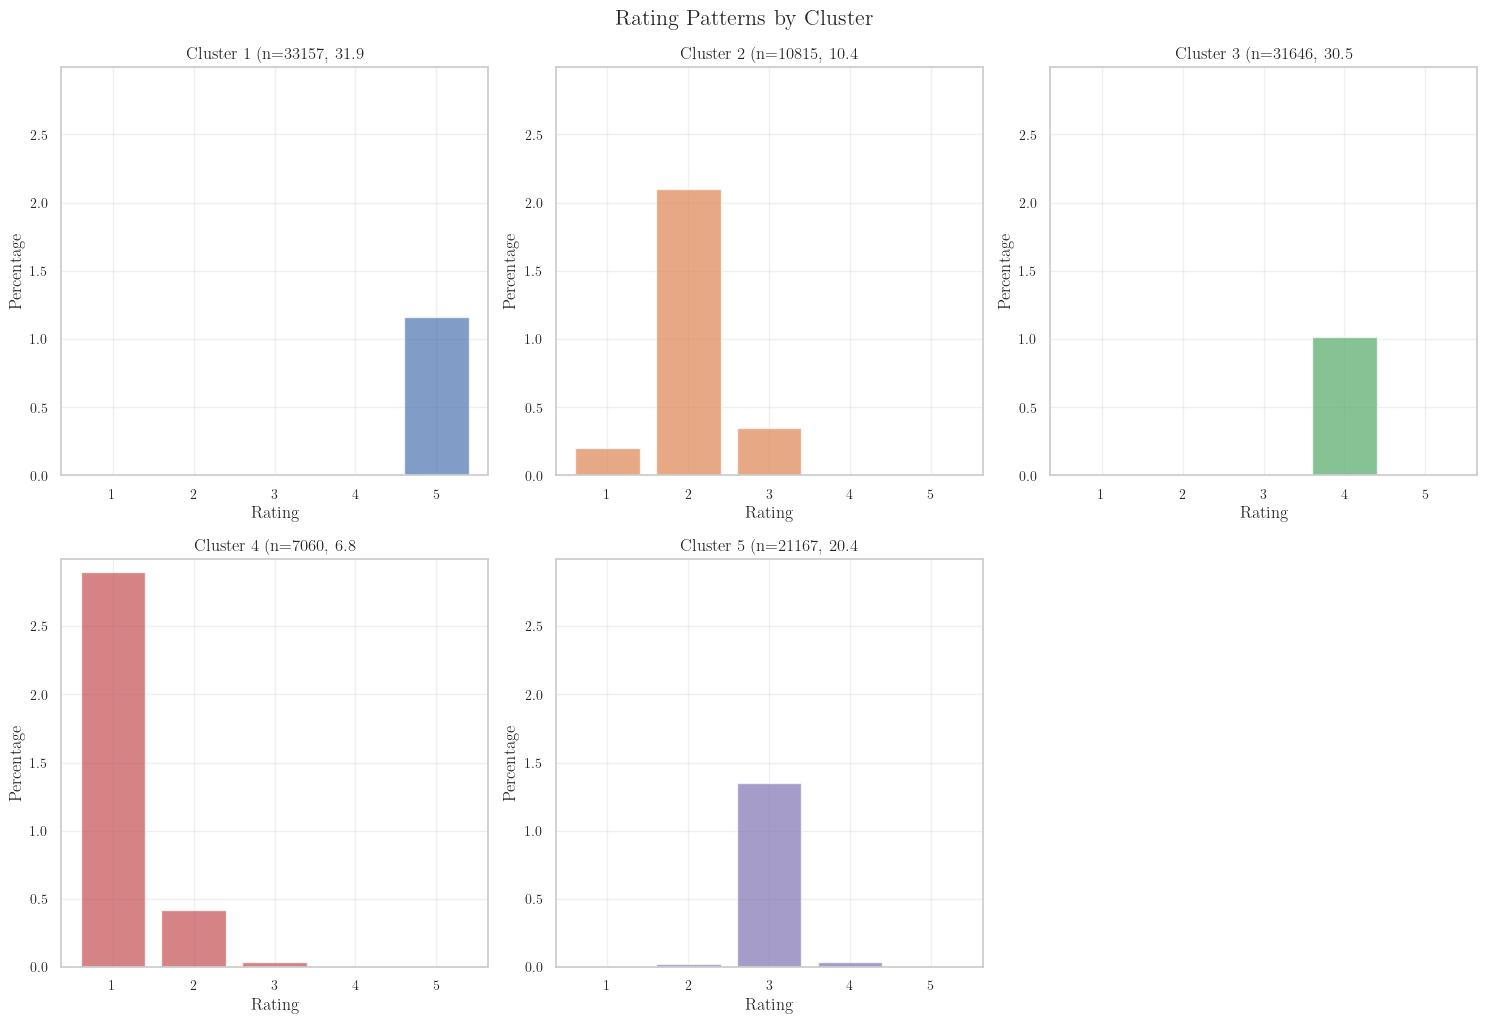

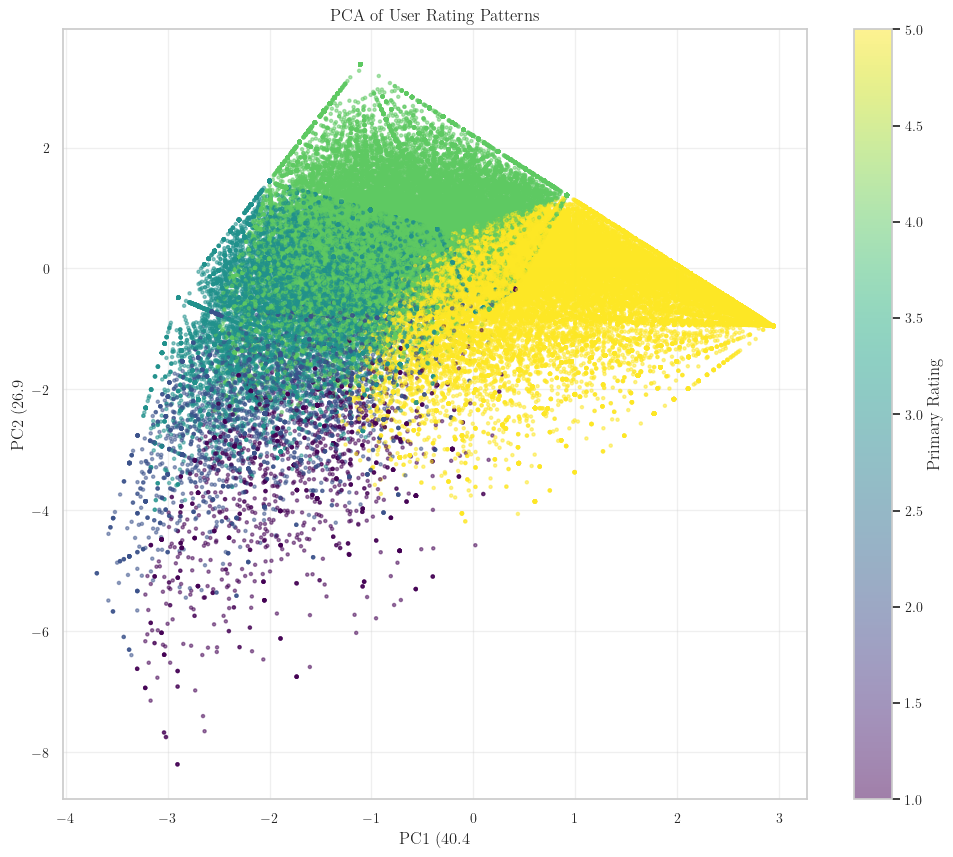

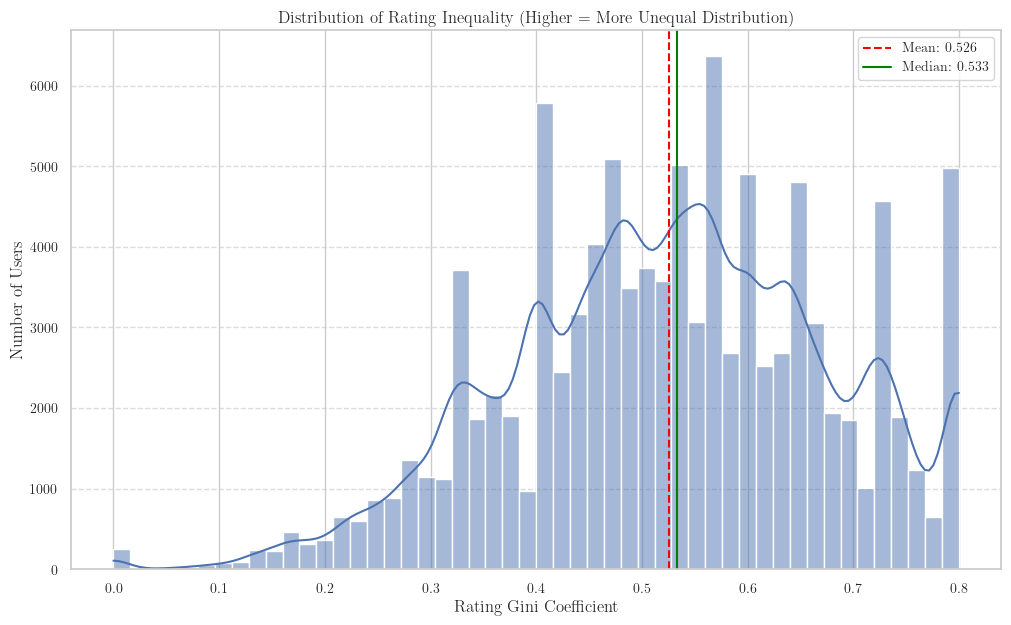

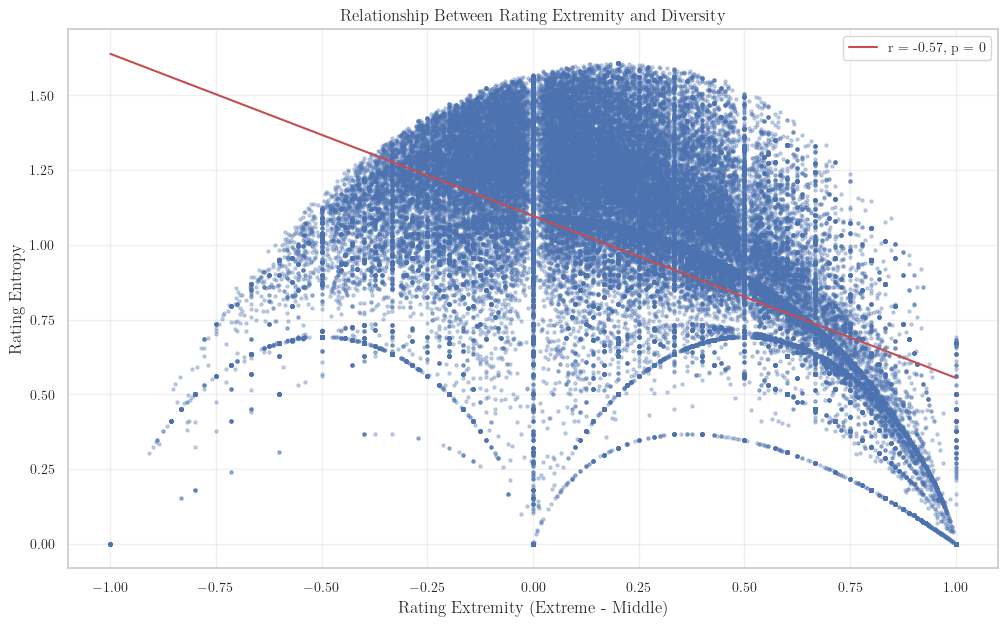

Analysis completed in 300.10 seconds
Total number of users analyzed: 103,845


In [18]:

# Generate detailed rating pattern fingerprints
bias_profiles = generate_rating_pattern_fingerprints()


## 8. Conclusion

This notebook has implemented advanced exploratory data analysis on the Goodreads Fantasy dataset using SQLite.

Key findings:
- Dataset integrity analysis revealed missing values and inconsistencies
- User behavior profiling identified different user segments
- Content landscape mapping provided insights into book distribution
- Reading pattern fingerprints captured temporal user behavior

These analyses help inform recommendation system design and feature engineering.